In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
from cliff_walking_org import CliffWalkingEnv
import random

In [20]:
class Agent(object):

    def __init__(self, env, policy, gamma, temp, alpha, epsilon=0.1):
        self.env = env
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.temp = temp
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        if policy == 'Boltzmann_Exploration':
            self.policy = self.Boltzmann_Exploration
        elif policy == 'egreedy_policy':
            self.policy = self.egreedy_policy
        
    def Boltzmann_Exploration(self, Q_val):
        prob = np.exp(Q_val / self.temp) / np.sum(np.exp(Q_val / self.temp))
        action = np.random.choice(len(Q_val), 1, p=prob)[0]
        return action, prob
    
    def egreedy_policy(self, Q_val):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space.n),_
        else:
            return np.argmax(Q_val),_

#     def egreedy_policy(self, Q_val):
#         A = np.ones(self.env.action_space.n, dtype=float) * self.epsilon / self.env.action_space.n
#         best_action = np.argmax(Q_val)
#         A[best_action] += (1.0 - self.epsilon)
#         return A

        
    def Qlearning(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Repeat for each step of episode
            while not done:
                # Choose action: Use Boltzmann_Exploration
                action, _ = self.policy(self.Q[state, :])
                #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
                #action = self.egreedy_policy(self.Q[state, :])
            
                
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                td_target = reward + self.gamma * np.max(self.Q[next_state, :])
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q
    
    def SARSA(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Choose action: Use Boltzmann_Exploration
            action, _ = self.policy(self.Q[state, :])
            #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
            #action = self.egreedy_policy(self.Q[state, :])

            # Repeat for each step of episode
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                next_action,_ = self.policy(self.Q[next_state, :])
                #next_action,_ = self.Boltzmann_Exploration(self.Q[next_state, :])
                #next_action = self.egreedy_policy(self.Q[next_state, :])

                td_target=reward + self.gamma*self.Q[next_state,next_action]
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                # a'=a
                action = next_action
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q
    
    def Expected_SARSA(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Choose action: Use Boltzmann_Exploration
            #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
            action, _ = self.policy(self.Q[state, :])


            # Repeat for each step of episode
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                #next_action, prob = self.Boltzmann_Exploration(self.Q[next_state, :])
                next_action, prob = self.policy(self.Q[next_state, :])

                td_target=reward + self.gamma*np.sum(prob*self.Q[next_state,:])
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                # a'=a
                action = next_action
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q

    def eval_(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Repeat for each step of episode
            while not done:
                #env.render()
                #time.sleep(0.5)
                # take greedy action
                action = np.argmax(self.Q[state, :])
                next_state, reward, done, _ = self.env.step(action)
                # s'=s
                state = next_state
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards




In [45]:
def run_experiments(env,policy,gamma,temp,alphas,epsilon=0.1):
    stack = {}
    r_a1 = []
    r_a2 = []
    r_a3 = []
    
    Expectedeval = []
    Seval = []
    Qeval = []
    
    for alpha in alphas:
        Qlearning = Agent(env,policy,gamma, temp, alpha, epsilon)
        SARSA = Agent(env, policy, gamma, temp, alpha, epsilon)
        Expected_SARSA = Agent(env, policy, gamma, temp, alpha, epsilon)

        reward1,Q1 = Qlearning.Qlearning(episodes=500)
        reward2,Q2 = SARSA.SARSA(episodes=500)
        reward3,Q3 = Expected_SARSA.Expected_SARSA(episodes=500)
        
        Qeval.append(Qlearning.eval_(episodes=1) )
        Seval.append(SARSA.eval_(episodes=1) )
        Expectedeval.append(Expected_SARSA.eval_(episodes=1))
        

        # mean over all episodic reward
        r_a1.append(np.mean(reward1))
        r_a2.append(np.mean(reward2))
        r_a3.append(np.mean(reward3))
        
# if you want mean of last 10 episodes
#         r_a1.append(np.mean(reward1[-10:]))
#         r_a2.append(np.mean(reward2[-10:]))
#         r_a3.append(np.mean(reward3[-10:]))
        
    stack['Qlearning']=r_a1
    stack['SARSA']=r_a2
    stack['Expected_SARSA']=r_a3
        
    stack['Qeval']=Qeval
    stack['Seval']=Seval
    stack['Expectedeval']=Expectedeval

        
    return stack

In [36]:
alphas = np.linspace(0.1,1,10)
gamma = 1  # disocunt factor
#env = gym.make('Taxi-v2')
env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temp = 0.5
results = run_experiments(env,policy,gamma,temp,alphas,epsilon=0.1)

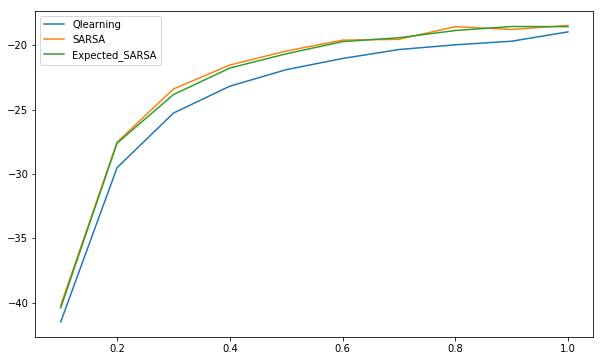

In [40]:
plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qlearning'], label='Qlearning')
plt.plot(alphas, results['SARSA'], label='SARSA')
plt.plot(alphas, results['Expected_SARSA'], label='Expected_SARSA')
plt.legend()
plt.show()

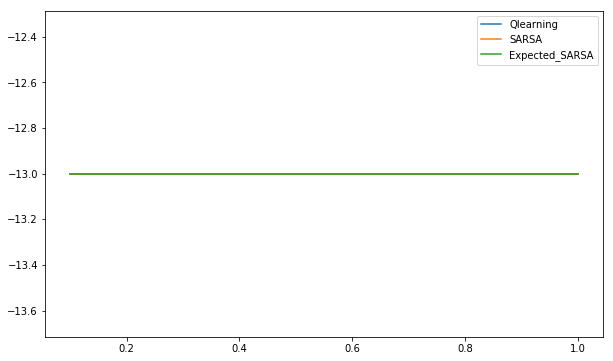

In [42]:
plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qeval'], label='Qlearning')
plt.plot(alphas, results['Seval'], label='SARSA')
plt.plot(alphas, results['Expectedeval'], label='Expected_SARSA')
plt.legend()
plt.show()

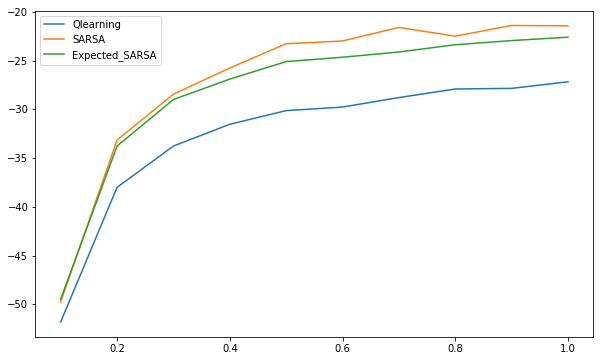

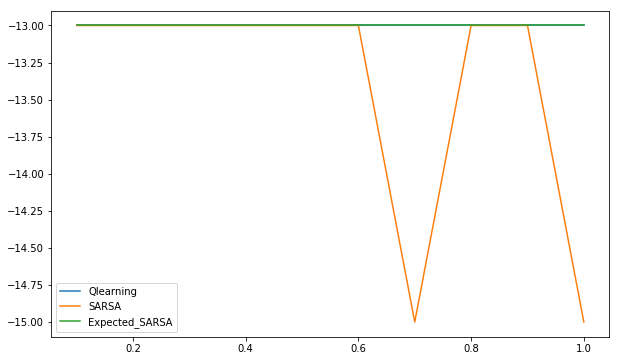

In [46]:
alphas = np.linspace(0.1,1,10)
gamma = 1  # disocunt factor
#env = gym.make('Taxi-v2')
env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temp = 1
results = run_experiments(env,policy,gamma,temp,alphas,epsilon=0.1)

plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qlearning'], label='Qlearning')
plt.plot(alphas, results['SARSA'], label='SARSA')
plt.plot(alphas, results['Expected_SARSA'], label='Expected_SARSA')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qeval'], label='Qlearning')
plt.plot(alphas, results['Seval'], label='SARSA')
plt.plot(alphas, results['Expectedeval'], label='Expected_SARSA')
plt.legend()
plt.show()

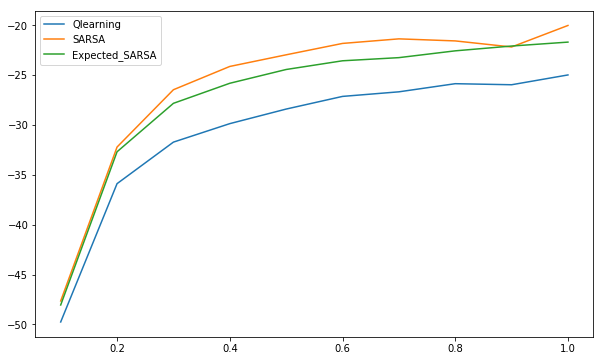

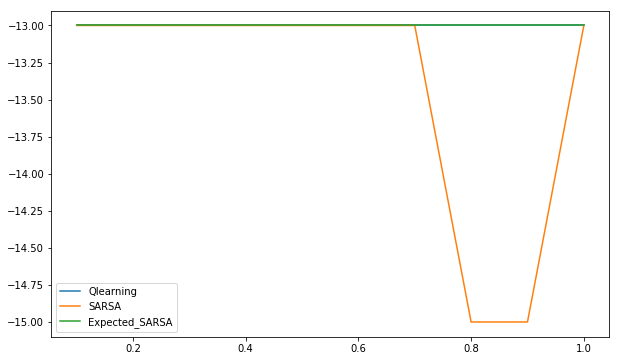

In [47]:
alphas = np.linspace(0.1,1,10)
gamma = 1  # disocunt factor
#env = gym.make('Taxi-v2')
env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temp = 0.9
results = run_experiments(env,policy,gamma,temp,alphas,epsilon=0.1)

plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qlearning'], label='Qlearning')
plt.plot(alphas, results['SARSA'], label='SARSA')
plt.plot(alphas, results['Expected_SARSA'], label='Expected_SARSA')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(alphas, results['Qeval'], label='Qlearning')
plt.plot(alphas, results['Seval'], label='SARSA')
plt.plot(alphas, results['Expectedeval'], label='Expected_SARSA')
plt.legend()
plt.show()

In [48]:
alphas = np.linspace(0.1,1,10)
gamma = 1  # disocunt factor
#env = gym.make('Taxi-v2')
env = CliffWalkingEnv()

r_a1 = []
r_a2 = []
#r_a3 = []
policy ='egreedy_policy'
temp = 1
for alpha in alphas:
    Qlearning = Agent(env,policy,gamma, temp, alpha=alpha, epsilon=0.1)
    SARSA = Agent(env, policy, gamma, temp, alpha=alpha, epsilon=0.1)
    #Expected_SARSA = Agent(env, policy, gamma, temp, alpha=alpha, epsilon=0.1)
    
    reward1,Q1 = Qlearning.Qlearning(episodes=500)
    reward2,Q2 = SARSA.SARSA(episodes=500)
    #reward3,Q3 = Expected_SARSA.Expected_SARSA(episodes=500)
    
    r_a1.append(np.mean(reward1))
    r_a2.append(np.mean(reward2))
    #r_a3.append(np.mean(reward3))

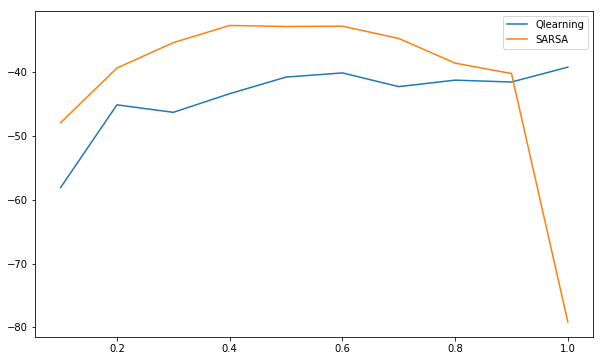

In [49]:
plt.figure(figsize=(10,6))
plt.plot(alphas, r_a1, label='Qlearning')
plt.plot(alphas, r_a2, label='SARSA')
#plt.plot(alphas, r_a3, label='Expected_SARSA')
plt.legend()
plt.show()